In [1]:
#pip install kalepy

In [2]:
import pandas as pd
import numpy as np
from kde_diffusion import kde1d
from scipy import integrate
from scipy.stats import norm, lognorm, iqr
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV, LeaveOneOut, KFold

np.random.seed(0)

In [3]:
# simulate log normal data, n observations
n = 1000
s = 1 
x = lognorm.rvs(s=s, size=n)

In [4]:
# Use K-fold Cross Validation to find optimal bandwidth for Kernel Density Estimation (h_cv)

bandwidths = 10 ** np.linspace(-1, 1, 200)

grid_cv_ing = GridSearchCV(KernelDensity(kernel='gaussian'),
                           {'bandwidth': bandwidths},
                           cv=KFold(n_splits=5))

grid_cv_ing.fit(x[:, None]);

h_cv      = grid_cv_ing.best_params_['bandwidth']

# Silvermans rule of thumb for bandwidth (h_silv)
h_silv    = 0.9*min(np.std(x), iqr(x)/1.34)*n**(-1/5)

In [5]:
# Kernel Density Estimates for h_cv and h_silv
kde_cv    = KernelDensity(kernel='gaussian', bandwidth=h_cv).fit(x[:, None])
kde_silv  = KernelDensity(kernel='gaussian', bandwidth=h_silv).fit(x[:, None])

In [6]:
# Computes arrays for plotting
x_lognorm  = np.linspace(lognorm.ppf(0.001, s),
                         lognorm.ppf(0.999, s), 2000)

x_kde_grid   = np.linspace(x.min(), x.max(), 2000)
pdf_kde_cv   = np.exp(kde_cv.score_samples(x_kde_grid[:, None]))
pdf_kde_silv = np.exp(kde_silv.score_samples(x_kde_grid[:, None]))

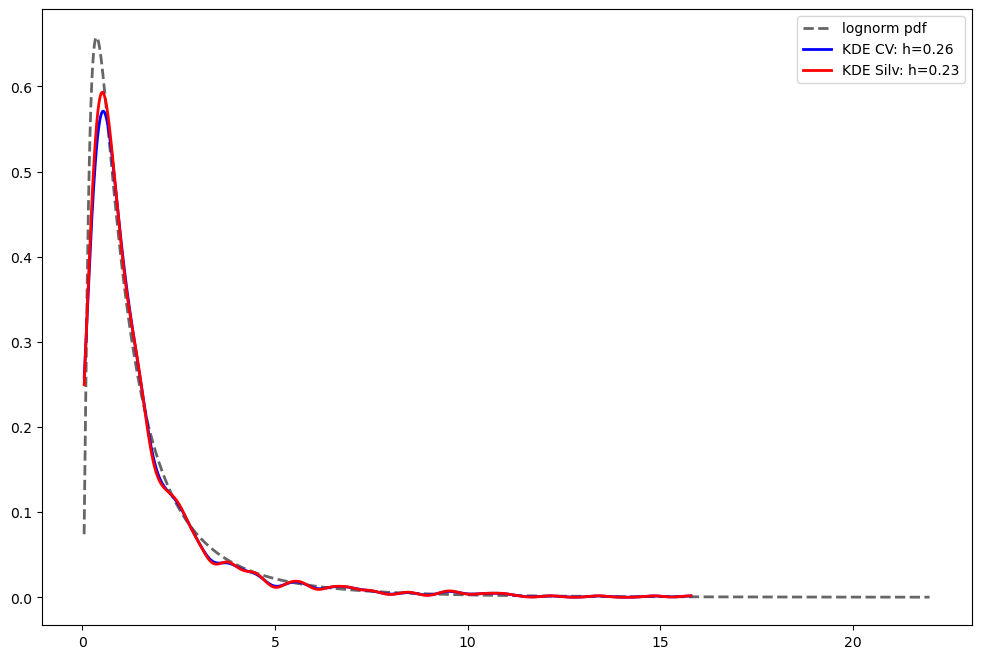

In [7]:
# Plots of KDEs and Population Density
fig, ax = plt.subplots(figsize=(12, 8))


plt.plot(x_lognorm, lognorm.pdf(x_lognorm, s),
       color='k', linestyle='--', lw=2, alpha=0.6, label='lognorm pdf')

plt.plot(x_kde_grid, pdf_kde_cv, linewidth=2,
         alpha=1, label='KDE CV: ' 'h=%.2f' % h_cv, color='blue')

plt.plot(x_kde_grid, pdf_kde_silv, linewidth=2,
         alpha=1, label='KDE Silv: ' 'h=%.2f' % h_silv, color='red')

#plt.xlim(-0.01,15)
plt.legend()

In [8]:
# Compute 'Mass' that does not correspond to the context of data, that is,
# the KDE has boundary problems of estimation, and we know from context that
# the datum are non-negative, so we check how much 'mass' is being assigned to
# negative numbers, and then we correct the KDE by assingating the 'mass' outside
# the support of the random variable to inside.
out_x_kde_grid   = np.linspace(-1.5, 0, 2000)
out_pdf_kde_cv   = np.exp(kde_cv.score_samples(out_x_kde_grid[:, None]))
out_pdf_kde_silv = np.exp(kde_silv.score_samples(out_x_kde_grid[:, None]))

out_F_cv  = integrate.simpson(out_pdf_kde_cv, out_x_kde_grid)
out_F_silv = integrate.simpson(out_pdf_kde_silv, out_x_kde_grid)

In [9]:
# Truncation correction for KDE
trunc_corr_pdf_kde_cv   = pdf_kde_cv/(1-out_F_cv)
trunc_corr_pdf_kde_silv = pdf_kde_silv/(1-out_F_silv)

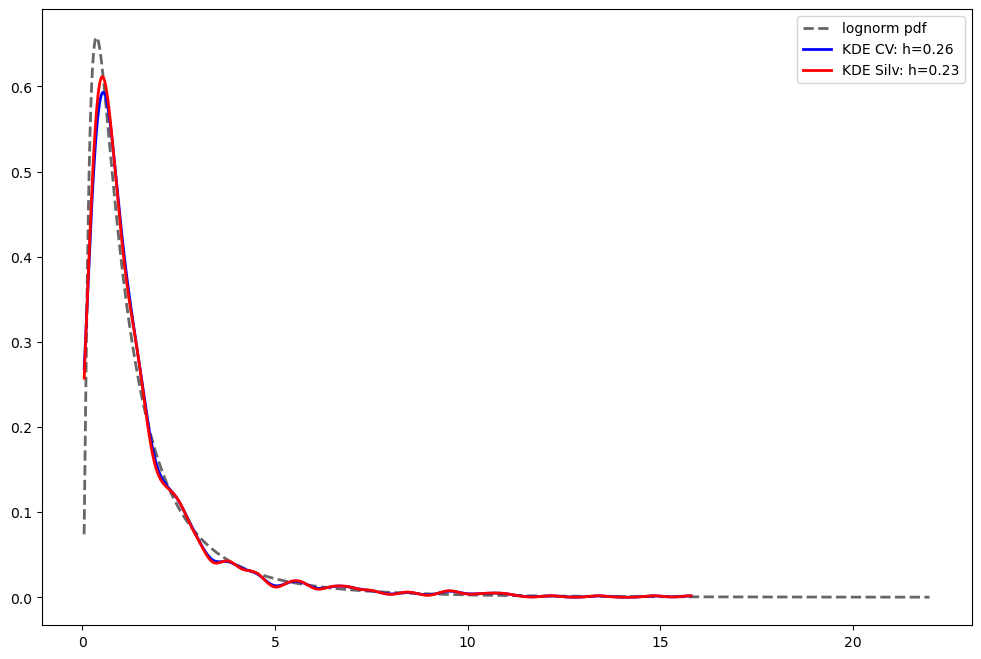

In [15]:
# Plot of Truncation Corrected KDEs
fig, ax = plt.subplots(figsize=(12, 8))


plt.plot(x_lognorm, lognorm.pdf(x_lognorm, s),
       color='k', linestyle='--', lw=2, alpha=0.6, label='lognorm pdf')

plt.plot(x_kde_grid, trunc_corr_pdf_kde_cv, linewidth=2,
         alpha=1, label='KDE CV: ' 'h=%.2f' % h_cv, color='blue')

plt.plot(x_kde_grid, trunc_corr_pdf_kde_silv, linewidth=2,
         alpha=1, label='KDE Silv: ' 'h=%.2f' % h_silv, color='red')

#plt.xlim(-0.01,15)
plt.legend()

In [12]:
# Integration to Estimate Distribution Function from KDEs
F_aprox = np.zeros(x_lognorm.shape[0])

F_aprox_kde_cv = np.zeros(x_kde_grid.shape[0])
F_aprox_kde_silv = np.zeros(x_kde_grid.shape[0])


trunc_corr_F_aprox_kde_cv = np.zeros(x_kde_grid.shape[0])
trunc_corr_F_aprox_kde_silv = np.zeros(x_kde_grid.shape[0])


for i in range(1,  x_lognorm.shape[0]):
    F_aprox[i] = integrate.simpson(lognorm.pdf(x_lognorm, s)[x_lognorm < x_lognorm[i]],
                                   x_lognorm[x_lognorm < x_lognorm[i]])
    
    
for i in range(1,  x_kde_grid.shape[0]):    
    F_aprox_kde_cv[i]   = integrate.simpson(pdf_kde_cv[x_kde_grid < x_kde_grid[i]],
                                            x_kde_grid[x_kde_grid < x_kde_grid[i]])
    F_aprox_kde_silv[i] = integrate.simpson(pdf_kde_silv[x_kde_grid < x_kde_grid[i]],
                                            x_kde_grid[x_kde_grid < x_kde_grid[i]])
    
    
for i in range(1,  x_kde_grid.shape[0]):    
    trunc_corr_F_aprox_kde_cv[i]   = integrate.simpson(trunc_corr_pdf_kde_cv[x_kde_grid < x_kde_grid[i]],
                                            x_kde_grid[x_kde_grid < x_kde_grid[i]])
    trunc_corr_F_aprox_kde_silv[i] = integrate.simpson(trunc_corr_pdf_kde_silv[x_kde_grid < x_kde_grid[i]],
                                            x_kde_grid[x_kde_grid < x_kde_grid[i]])

(0.0, 10.0)

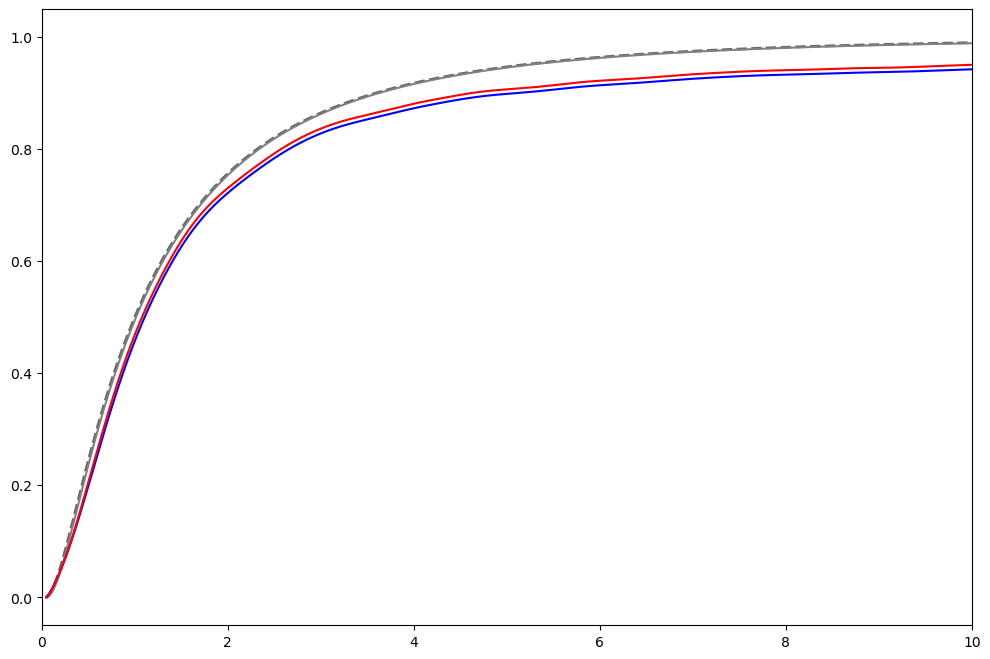

In [13]:
# Plot of DF
fig, ax = plt.subplots(figsize=(12, 8))


plt.plot(x_lognorm, lognorm.cdf(x_lognorm, s),
       color='k', linestyle='--', lw=2, alpha=0.6, label='lognorm pdf')


plt.plot(x_lognorm, F_aprox, label='Aprox. using population density', color='grey')
plt.plot(x_kde_grid, F_aprox_kde_cv,   label='Aprox. using population density', color='blue')
plt.plot(x_kde_grid, F_aprox_kde_silv, label='Aprox. using population density', color='red' )
plt.xlim(0,10)

(0.0, 10.0)

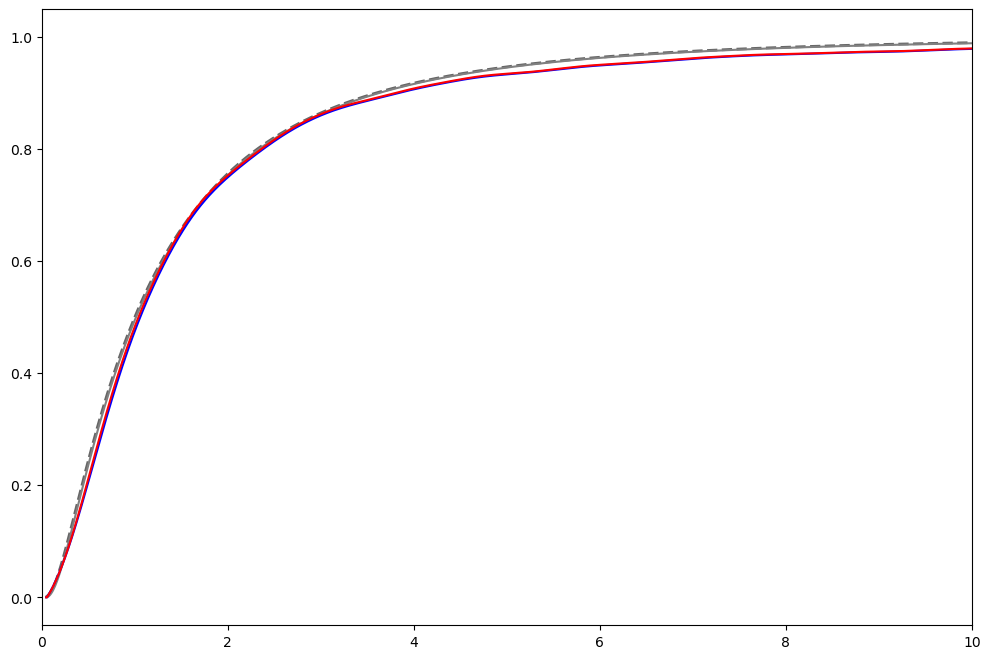

In [14]:
fig, ax = plt.subplots(figsize=(12, 8))


plt.plot(x_lognorm, lognorm.cdf(x_lognorm, s),
       color='k', linestyle='--', lw=2, alpha=0.6, label='lognorm pdf')


plt.plot(x_lognorm, F_aprox, label='Aprox. using population density', color='grey')
plt.plot(x_kde_grid, trunc_corr_F_aprox_kde_cv,   label='Aprox. using population density', color='blue')
plt.plot(x_kde_grid, trunc_corr_F_aprox_kde_silv, label='Aprox. using population density', color='red' )
plt.xlim(0,10)